# Secondary Loan Market Simulation Explanatory Notebook

## General Overview
In order to build a secondary loan market simulation, we will build iteratively on the concept that each loan tracks its own relevant information as it's passed between agents. Therefore, we will build the simulation by building each of the following elements in order:

- Loans: These need to be plausible securities and exist as the backbone of the entire simulation. The inidivudal loans have attributes based on random sampling from an associated distribution. Predicated on the assumption that attributes such as 'fair value' and 'PD/Probability of Default' are correalted, we will use a linear combination of random variables which incorporates a degree of noise while maintaining a target correlation between factors. Each loan will also track its own history of fair value and market price, as well as it's ownership history. 

- Investors: These are the main agents buying, selling and holding loans. The goal of this paper is to witness what kind of effects we see when we affect the decisions of these agents. These investors will buy, sell and collect profits or absorb losses based on realized gains/losses (the net worth of the portfolio is only based on realized amounts when the loans are bought and sold in order to mimic real value). The logic behind investor deicisons is pre-specified based on their current portfolio with each given a target 'risk/return' profile that they will made loan trades in order to approach.  

- Traders: These are the agents that act as the intermediary between investors and each other. The loan will need to appear on a trader's 'Offers-Wanted-In-Competition' or 'Buyers-Wanted-In-Competition' in order to be traded. The trader will also need to be able to make offers on loans that appear on the 'Buyers-Wanted-In-Competition' list. These specific trades occur on an intra-cycle basis and the trading agents are responsible for finally allocating the loan to the investor within that update cycle. The next investor would then hold the loan and be responsible for updating it. 




### The Loan Class

In [19]:
import time
import uuid
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

class Loan:
    def __init__(self, current_cycle=0, current_owner="no owner"):
        self.id = str(uuid.uuid4())
        self.maturity = np.random.randint(3, 8)  # 3 to 7 inclusive
        self.current_cycle = current_cycle
        self.starting_cycle = self.current_cycle
        self.ending_cycle = self.starting_cycle + self.maturity
        self.time_to_maturity = self.ending_cycle - self.current_cycle
        self.pd = np.random.beta(1, 50)
        self.size = np.random.uniform(500_000, 5_000_000)
        self.interest_rate = self.generate_interest_rate()
        
        # tracking attributes
        self.fair_value = self.calculate_price()
        self.fair_value_history = []
        self.market_price = self.fair_value
        self.market_price_history = []
        self.current_owner = current_owner
        self.ownership_history = [current_owner]
        self.maturity_bool = False
    
    def generate_interest_rate(self):
        base_level_noise = np.random.normal(0.02, 0.005)  # Normal distribution centered around 2%
        correlation_factor = 0.8  # A correlation centered around 80%
        influence_factor = np.random.uniform(0.05, 0.15)
        correlated_component = correlation_factor * self.pd * influence_factor
        return base_level_noise + correlated_component
    
    def calculate_price(self):
        beta1 = np.random.normal(-7, 1)
        pd_effect = beta1 * self.pd
        if self.pd > 0.2:
            pd_effect *= 2  # Double the negative effect for PD > 0.2 as a penalty for excess risk
        beta2 = np.random.normal(5, 1)
        ir_effect = beta2 * self.interest_rate
        beta3 = np.random.uniform(-0.0000002, 0)  # Coefficient to scale price/size effect
        size_effect = beta3 * self.size
        intermediate_price = np.random.normal(100, 0.5) + pd_effect + ir_effect + size_effect
        k = 0.5  # decay constant for time to maturity
        maturity_effect = (intermediate_price - 100) * np.exp(-k * self.time_to_maturity)
        final_price = intermediate_price - maturity_effect
        return final_price
    
    @staticmethod
    def generate():
        return Loan()
    
    def update_owner(self, new_owner):
        self.current_owner = new_owner
        self.ownership_history.append(new_owner)
        
    
    def update(self, current_cycle, new_owner = None, new_market_price=None):

        if current_cycle > self.ending_cycle:
            return
        
        if new_owner:
            self.update_owner(new_owner)
        
        self.current_cycle = current_cycle
        self.time_to_maturity = self.ending_cycle - self.current_cycle
        self.fair_value = self.calculate_price()
        
        if new_market_price:
            self.market_price = new_market_price
        self.market_price_history.append(self.market_price)
        
        # Loan maturity logic
        if current_cycle == self.ending_cycle:
            self.maturity_bool = True
            default_outcome = np.random.rand() < self.pd
            if default_outcome:
                self.fair_value = np.random.normal(10, 2)
                self.market_price = self.fair_value  # Set to liquidation value
            else:
                self.fair_value = 100  # Set to par value
                self.market_price = 100  # Set to par value
        self.fair_value_history.append(self.fair_value)

### Investor and Trader Classes

Next we will build the investor and trader classes. We'll start with a simple example of a double auction as an example of how typical liquid markets are structured. The loan market however is illiquid and a single auction would need to be used.

In this simple example, we see how the market matches the buy and sell order where the lowest sell order is accepted. We will extend this logic by creating an investor class that will submit the orders to the traders. The traders would then be responsible for matching the buyers and sellers in the market itself. Here are the key attributes of the investor class:

1. ID: That uniquely differentiates itself from other investors
2. Capital: Available to invest. Denominated in currency units (for this exercise dollars). This is a running list that tracks returns including interest and defaults. 
3. Risk/return target. This will correspond to the aggregate level of returns the investor is looking to achieve and be equal to PD/interest rate. This will be used to determine which loans the investor will choose as they look to get their portfolio to this target risk/return for active loans (loan's that have not matured yet).
4. Portfolio. This will be a list of loans that the investor currently owns. This will be used to calculate the current risk/return of the portfolio and determine which loans to sell or buy in order to get to the target risk/return.
5. Current risk/return score: Calculated risk/return score of the portfolio. This will be used to determine which loans to buy or sell in order to get to the target risk/return.
6. To sell: Based on the current risk return score, the investor decides to sell the loan with the greatest wrong-way impact on the risk/return score. This will be a list of loan IDs that the investor will sell. Limited to 1 loan per cycle.
7. To Buy: This is a target value from which the investor would decide to buy loans or not. This is an intelligent calculation that determines what loans are missing to get a target risk return score. 

Here are the things the investor will do to initialize. This will create the initial set of investors where we will need to allocate capital:
1. Create ID: Use UUID to create a unique ID for the investor
2. Generate initial capital: Use a random distribution to generate an initial capital amount
3. Generate target risk/return score: Use a random distribution to generate a target risk/return score

Next we will create the set of traders which will take the set of investors as inputs. The traders will have the following attributes: 
1. ID: That uniquely differentiates itself from other traders
2. Investors: List of investors that the trader will be responsible for
3. Offers-Wanted-In-Competition: List of loans that their investors are looking to sell and the price they are looking to sell at

Cycle 0: Initializing the simulation class:
1. Create loan universe: number of loans
2. Create investor universe: number of investors
3. Create trader universe: number of traders, takes the investor IDs as inputs

Allocations:
1. Allocate loans to investors: Based on the amount of capital investors have, allocate loans to investors. This will be done by sorting the loans by their fair value and allocating the biggest loans to the investors with the highest capital until they reach 90% of their capital.
2. Run the relevant calculations on the investors to determine where their current risk/return profile is and the directionality for target risk return score.
3. Based on the difference between target and current risk/return score, determine which loans to sell and which loans to buy

Updating each cycle:
1. Update the loans: Update the loans to the next cycle and update the fair value.
2. Update the investors: Update the investors to include their new capital including the interest accumulated from their loan and if their loans have matured.
3. Update the investors: Form a list of loans to sell and a threshold for loans to buy. 
4. Traders create a new OWIC list: Based on the loans to sell, the traders will create a new OWIC list with the loans to sell and the price they are looking to sell at.
5. Auction conducted for loans to sell: Elaborated on below
6. Investors portfolios updated for next cycle: Capital, loan list, and risk score is recalculated.
7. Repeat...

The Auction Process. The Goal of this auction process is to conduct a sealed bid auction in which the traders will submit their bids for the loans that are on the OWIC list. The traders will then match the bids with the offers and allocate the loans to the investors. Since every loan is coming in 'post-cycle', the only aspect to be updated is the owner. After a fun diversion into auction theory, the best outcome here is to select a maximum applicable bid and submit that. This avoids the back and forth of an auction while allowing for the maximum price to be paid for the loan by each investor. This should theoretically match supply and demand by giving each investor an ideal risk-adjusted price for the loan that they are looking to buy.




#### Investor Class

Showing the basic functionality of the investor class to initialize and update the investor's portfolio over a series of cycles. The following block represents an initial representation of the investor class in which they are initially allocated the loans and the process by which their portfolio is able to update based on holding a series of loans.

In [20]:
class LoanInvestor:
    def __init__(self, trader=None, capital=None):
        self.id = 'I'+str(uuid.uuid4())
        self.capital = capital if capital else self.generate_initial_capital()
        self.capital_history = []
        self.target_score = np.random.uniform(0, 2)
        self.loan_fair_values = []
        self.portfolio_values = []
        self.portfolio = []
        self.matured_loans = []
        self.current_score = 0
        self.trader = trader
        self.interest_received = []
    
    def generate_initial_capital(self):
        random_capital = np.round((np.random.pareto(2, 1) + 1)*50*1000000, 0)[0]
        return random_capital
    
    def initialize_portfolio(self, available_loans, capital_threshold=0.9):
        np.random.shuffle(available_loans)
        total_investment = 0
        for loan in available_loans:
            purchase_value = (loan.market_price/100) * loan.size
            if total_investment + purchase_value <= self.capital*capital_threshold:
                total_investment += purchase_value
                loan.update_owner(self.id)
                self.portfolio.append(loan)
            else:
                self.capital -= total_investment
                break
        self.calculate_current_score()
        self.loan_fair_values.append(np.sum([(loan.fair_value * (loan.size/100)) for loan in self.portfolio]))
        self.portfolio_values.append(self.loan_fair_values[-1] + self.capital)
        self.capital_history.append(self.capital)
        
    def calculate_value(self):
        self.loan_fair_values.append(np.sum([((loan.fair_value/100) * loan.size) for loan in self.portfolio]))
        self.portfolio_values.append(self.loan_fair_values[-1] + self.capital)
        self.capital_history.append(self.capital)
        
    def calculate_current_score(self):
        weighted_interest = sum([loan.interest_rate * loan.size for loan in self.portfolio])
        weighted_pd = sum([loan.pd * loan.size for loan in self.portfolio])
        total_size = sum([loan.size for loan in self.portfolio])
        self.current_score = (weighted_interest / total_size) / (weighted_pd / total_size) if weighted_interest >0 else 0
        
    def get_loans_to_sell(self):
        return
    
    def get_bid_price(self, loan):
        return
    
    def receive_interest(self, float_interest = 0):
        '''
        This is the procedure every cycle for the investor to receive interest on their loans. 
        :param float_interest: The floating base rate for interest (think SOFR)
        '''
        total_interest = 0
        for loan in self.portfolio:
            if loan.maturity_bool==True:
                self.capital += (loan.fair_value/100) * loan.size
                self.matured_loans.append(loan)
                self.portfolio.remove(loan)
            else:
                total_interest += loan.size * (loan.interest_rate + float_interest)
                
        self.capital += total_interest
        self.interest_received.append(total_interest)
        
    def update(self, float_interest = 0):
        self.receive_interest(float_interest)
        self.calculate_value()
        self.calculate_current_score()

In [21]:
class trader:
    def __init__(self, max_investors = 10):
        self.id = 'T'+str(uuid.uuid4())
        self.max_investors = max_investors
        self.max_investors_reached = False
        self.loans_for_sale = []
        self.investors = []
    
    def add_investor(self, investors):
        for investor in investors:
            if investor.trader == None and len(self.investors) < self.max_investors:
                self.investors.append(investor)
                investor.trader = self
            else:
                self.max_investors_reached = True
                pass
            
    def initialize_book(self, available_loans):
        self.loans_for_sale.append(available_loans)
        for loan in available_loans:
            loan.update_owner(self.id)
    
    def run_auction(self):
        return

In [46]:
class loanMarket:
    def __init__(self, num_loans, num_investors, num_traders):
        self.num_loans = num_loans
        self.num_investors = num_investors
        self.num_traders = num_traders
        
        # creating the universe of loans
        self.loans = [Loan() for _ in range(self.num_loans)]
        
        # creating the universe of investors
        self.investors = [LoanInvestor() for _ in range(self.num_investors)]
        
        # creating the universe of traders
        self.traders = [trader(max_investors = self.num_investors//self.num_traders) for _ in range(self.num_traders)]
        
    
    def initialize(self):
        
        for investor in self.investors:
            # regenerating list of available loans
            available_loans = [loan for loan in self.loans if loan.current_owner == "no owner"]
            investor.initialize_portfolio(available_loans)
        
        # assigning the leftover unsold loans to the individual traders
        unsold_loans_initial = len([loan for loan in self.loans if loan.current_owner == "no owner"])
        for trader_ in self.traders:
            unsold_loans = [loan for loan in self.loans if loan.current_owner == "no owner"]
            trader_.initialize_book(np.random.choice(unsold_loans, size = unsold_loans_initial//(self.num_traders), replace = False))
            
            # assigning investors to the traders up to the traders max investors
            if trader_.max_investors_reached == False:
                trader_.add_investor(self.investors)
            else:
                pass
        
        # randomly assigning any leftover loans to the traders
        for loan in self.loans:
            if loan.current_owner == "no owner":
                trader = np.random.choice(self.traders)
                loan.update_owner(trader.id)
                trader.loans_for_sale.append(loan)
                
        # randomly assigning any leftover investors to traders
        for investor in self.investors:
            if investor.trader == None:
                trader = np.random.choice(self.traders)
                trader.investors.append(investor)
                investor.trader = trader
            else:
                pass
            
    def update(self):
        for loan in loans:
            # loans are updated independent of investors
            loan.update(cycle+1)
        for investor in investors:
            # investors are updated based on the loans they hold
            investor.update()
      

In [47]:
loan_Market = loanMarket(10000, 122, 80)
loan_Market.initialize()

In [24]:
num_loans = 5000
num_investors = 100

# testing the loan investor by creating a series of investors to hold the loans we generated above
loans = [Loan() for _ in range(num_loans)]

# creating investors
investors = [LoanInvestor() for _ in range(num_investors)]

investor_ids = [investor.id for investor in investors]

# initializing the portfolios
for investor in investors:
    # regenerating list of available loans
    available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
    investor.initialize_portfolio(available_loans)
    
# testing update logic
num_cycles = 10

for cycle in range(num_cycles):
    for loan in loans:
        # loans are updated independent of investors
        loan.update(cycle+1)
    for investor in investors:
        # investors are updated based on the loans they hold
        investor.update()

In [25]:
num_loans = 5000
num_investors = 100

# testing the loan investor by creating a series of investors to hold the loans we generated above
loans = [Loan() for _ in range(num_loans)]

# creating investors
investors = [LoanInvestor() for _ in range(num_investors)]

# initializing the portfolios
for investor in investors:
    # regenerating list of available loans
    available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
    investor.initialize_portfolio(available_loans)

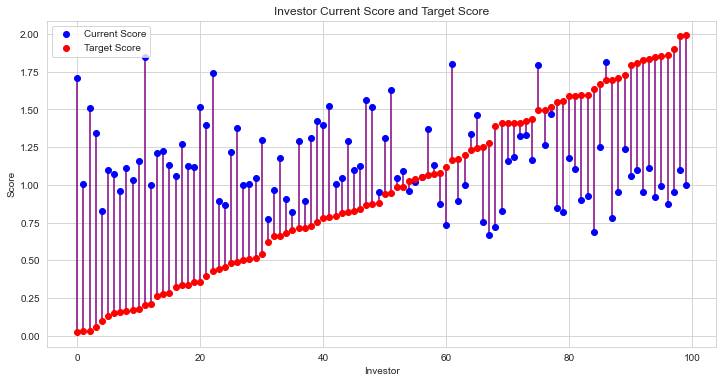

In [26]:
# Sorting the scores for a more organized visualization
current_scores = np.array([investor.current_score for investor in investors])
target_scores= np.array([investor.target_score for investor in investors])

# Sorting the scores for a more organized visualization
indices = np.argsort(target_scores)
current_scores_sorted = current_scores[indices]
target_scores_sorted = target_scores[indices]

# Creating a scatter plot with connected lines
plt.figure(figsize=(12, 6))
for i in range(num_investors):
    plt.plot([i, i], [current_scores_sorted[i], target_scores_sorted[i]], color='purple')  # lines
plt.scatter(range(num_investors), current_scores_sorted, color='blue', label='Current Score', zorder=5)
plt.scatter(range(num_investors), target_scores_sorted, color='red', label='Target Score', zorder=5)

plt.ylabel("Score")
plt.xlabel("Investor")
plt.title("Investor Current Score and Target Score")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

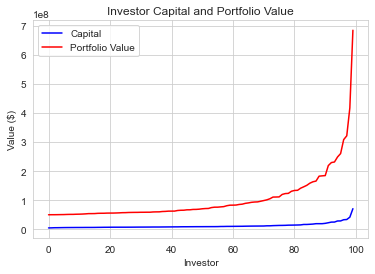

<Figure size 432x288 with 0 Axes>

In [27]:
# checking that the loans are allocated appropriately leaving about 10% of capital as a threshold for the loan investors
plt.plot(np.sort([investor.capital for investor in investors]), color = 'blue', label = 'Capital')
plt.plot(np.sort([investor.portfolio_values[-1] for investor in investors]), color = 'red', label = 'Portfolio Value')
plt.ylabel("Value ($)")
plt.xlabel("Investor")
plt.title("Investor Capital and Portfolio Value")
plt.legend()
plt.figure()

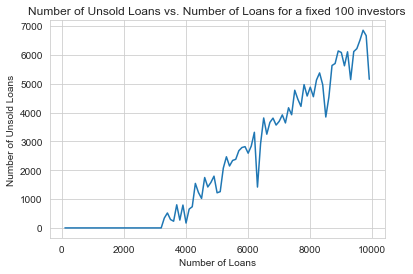

In [28]:
def get_unsold_loans(num_loans, num_investors):
    loans = [Loan() for _ in range(num_loans)]
    investors = [LoanInvestor() for _ in range(num_investors)]
    
    for investor in investors:
        # regenerating list of available loans
        available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
        investor.initialize_portfolio(available_loans)
    
    unsold_loan_num= len([loan for loan in loans if loan.current_owner == "no owner"])
    
    return unsold_loan_num

# generating a plot that shows how unsold loans scale with the number of loans versus investors
unsold_loans = [get_unsold_loans(num_loans, 100) for num_loans in range(100, 10000, 100)]
plt.plot(range(100, 10000, 100), unsold_loans)
plt.xlabel("Number of Loans")
plt.ylabel("Number of Unsold Loans")
plt.title("Number of Unsold Loans vs. Number of Loans for a fixed 100 investors")
plt.show()

## Adding in Updating Logic into the investor class and verifying it works

In [29]:
num_loans = 5000
num_investors = 100

# testing the loan investor by creating a series of investors to hold the loans we generated above
loans = [Loan() for _ in range(num_loans)]

# creating investors
investors = [LoanInvestor() for _ in range(num_investors)]

# initializing the portfolios
for investor in investors:
    # regenerating list of available loans
    available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
    investor.initialize_portfolio(available_loans)

# update for one cycle
for cycle in range(10):
    for loan in loans:
        loan.update(cycle+1)
    for investor in investors:
        investor.update()
        
    print("Cycle: ", cycle+1)
    print("Portfolio values: ", [investor.portfolio_values for investor in investors[0:1]])
    print("Capital: ", [investor.capital for investor in investors[0:1]])
    print("Interest Received: ", [investor.interest_received for investor in investors[0:1]])
    print("Loans: ", [len(investor.portfolio) for investor in investors[0:1]])
    print("Matured Loans: ", [len(investor.matured_loans) for investor in investors[0:1]])
    print("Current Score: ", [investor.current_score for investor in investors[0:1]])

Cycle:  1
Portfolio values:  [[140708110.0, 143456432.46743563]]
Capital:  [17354390.628056455]
Interest Received:  [[2686560.2326321206]]
Loans:  [50]
Matured Loans:  [0]
Current Score:  [0.9271037056500323]
Cycle:  2
Portfolio values:  [[140708110.0, 143456432.46743563, 146217641.8220894]]
Capital:  [20040950.860688575]
Interest Received:  [[2686560.2326321206, 2686560.2326321206]]
Loans:  [50]
Matured Loans:  [0]
Current Score:  [0.9271037056500323]
Cycle:  3
Portfolio values:  [[140708110.0, 143456432.46743563, 146217641.8220894, 143608351.35856116]]
Capital:  [46971847.83667813]
Interest Received:  [[2686560.2326321206, 2686560.2326321206, 1418598.7528608826]]
Loans:  [39]
Matured Loans:  [11]
Current Score:  [0.8656436990114992]
Cycle:  4
Portfolio values:  [[140708110.0, 143456432.46743563, 146217641.8220894, 143608351.35856116, 144858383.83360934]]
Capital:  [67698719.50474516]
Interest Received:  [[2686560.2326321206, 2686560.2326321206, 1418598.7528608826, 1074614.4712194062]

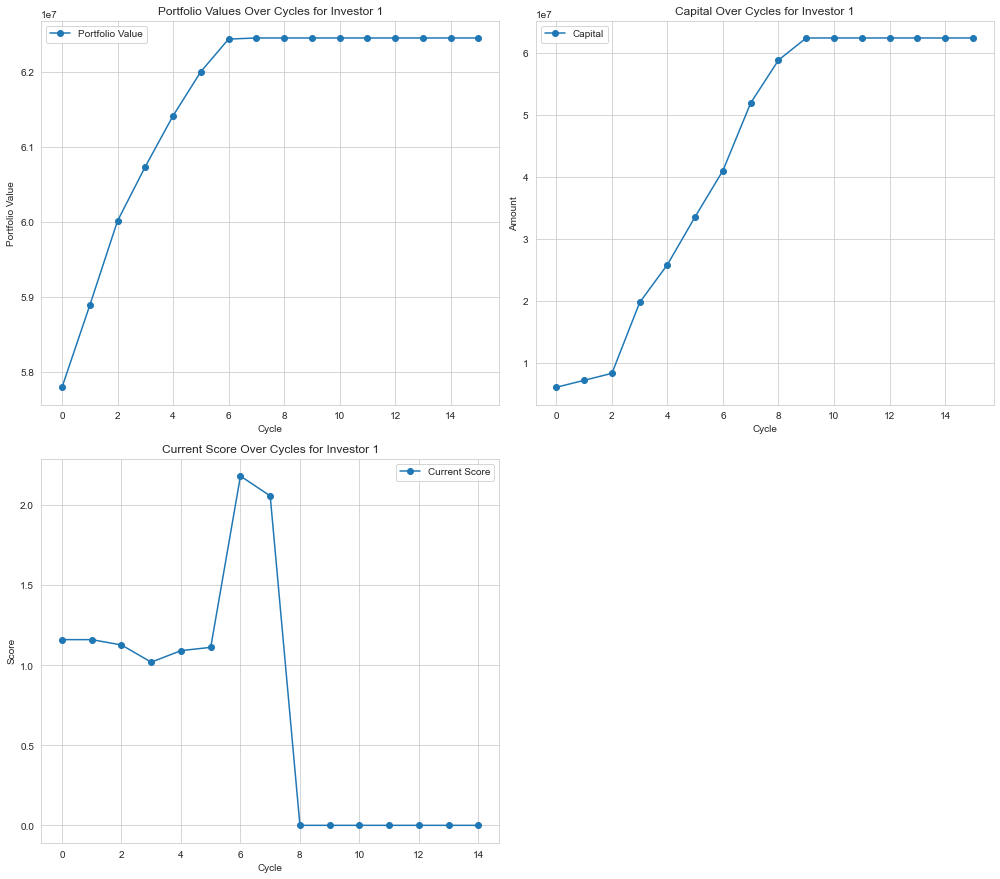

In [33]:
# Simulation parameters
num_cycles = 10
num_loans = 5000
num_investors = 100

# testing the loan investor by creating a series of investors to hold the loans we generated above
loans = [Loan() for _ in range(num_loans)]

# creating investors
investors = [LoanInvestor() for _ in range(num_investors)]

# initializing the portfolios
for investor in investors:
    # regenerating list of available loans
    available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
    investor.generate_initial_capital()
    investor.initialize_portfolio(available_loans)

interest_received = []
matured_loans = []
current_scores = []

# update for one cycle
for cycle in range(15):
    for loan in loans:
        loan.update(cycle+1)
    for investor in investors:
        investor.update()
        
    interest_received.append([investor.interest_received for investor in investors[0:1]])
    matured_loans.append([len(investor.matured_loans) for investor in investors[0:1]])
    current_scores.append([investor.current_score for investor in investors[0:1]])
    

# For the purpose of this visualization, we're using the data of the first investor as provided.
portfolio_values = [investor.portfolio_values for investor in investors[0:1]]
capital_history = [investor.capital_history for investor in investors[0:1]]


# Creating the plots
plt.figure(figsize=(14, 18))

# Portfolio Values Over Time
plt.subplot(321)
plt.plot(portfolio_values[0], marker='o', label='Portfolio Value')
plt.title('Portfolio Values Over Cycles for Investor 1')
plt.xlabel('Cycle')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()

# Capital and Interest Received Over Time
plt.subplot(322)
plt.plot(capital_history[0], marker='o', label='Capital')
plt.title('Capital Over Cycles for Investor 1')
plt.xlabel('Cycle')
plt.ylabel('Amount')
plt.grid(True)
plt.legend()


# Current Score Over Time
plt.subplot(323)
plt.plot(current_scores, marker='o', label='Current Score')
plt.title('Current Score Over Cycles for Investor 1')
plt.xlabel('Cycle')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

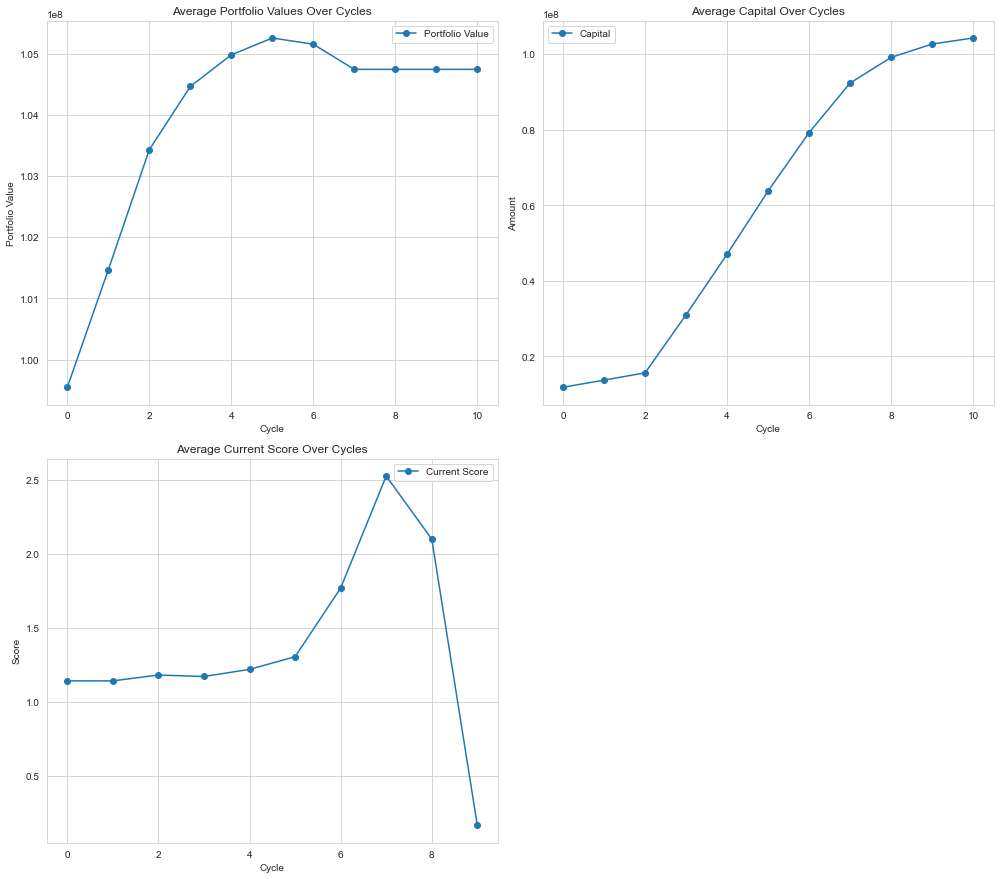

In [31]:
# Simulation parameters
num_cycles = 10
num_loans = 5000
num_investors = 100

# testing the loan investor by creating a series of investors to hold the loans we generated above
loans = [Loan() for _ in range(num_loans)]

# creating investors
investors = [LoanInvestor() for _ in range(num_investors)]

# initializing the portfolios
for investor in investors:
    # regenerating list of available loans
    available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
    investor.initialize_portfolio(available_loans)

interest_received = []
matured_loans = []
current_scores = []

# update for one cycle
for cycle in range(10):
    for loan in loans:
        loan.update(cycle+1)
    for investor in investors:
        investor.receive_interest()
        investor.calculate_value()
        investor.calculate_current_score()
        
    interest_received.append(np.mean([investor.interest_received for investor in investors]))
    matured_loans.append(np.mean([len(investor.matured_loans) for investor in investors]))
    current_scores.append(np.mean([investor.current_score for investor in investors]))
    

# For the purpose of this visualization, we're using the mean of all investors
portfolio_values = [investor.portfolio_values for investor in investors]
capital_history = [investor.capital_history for investor in investors]

portfolio_values = [sum(col) / len(col) for col in zip(*portfolio_values)]
capital_history = [sum(col) / len(col) for col in zip(*capital_history)]

# Creating the plots
plt.figure(figsize=(14, 18))


# Portfolio Values Over Time
plt.subplot(321)
plt.plot(portfolio_values, marker='o', label='Portfolio Value')
plt.title('Average Portfolio Values Over Cycles')
plt.xlabel('Cycle')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()

# Capital and Interest Received Over Time
plt.subplot(322)
plt.plot(capital_history, marker='o', label='Capital')
plt.title('Average Capital Over Cycles')
plt.xlabel('Cycle')
plt.ylabel('Amount')
plt.grid(True)
plt.legend()


# Current Score Over Time
plt.subplot(323)
plt.plot(current_scores, marker='o', label='Current Score')
plt.title('Average Current Score Over Cycles')
plt.xlabel('Cycle')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()